In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
path = ['E:/gp/Ocular_disease/glaucoma/dataset2/Train/Glaucoma_Negative', 'E:/gp/Ocular_disease/glaucoma/dataset2/Train/Glaucoma_Positive']
images = []
labels = []
for n,i in enumerate(path):
    for j in tqdm(os.listdir(i)):
        img_path = os.path.join(i,j)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

        #configure CLAHE
        clahe = cv2.createCLAHE(clipLimit=10,tileGridSize=(8,8))

        #0 to 'L' channel, 1 to 'a' channel, and 2 to 'b' channel
        img[:,:,0] = clahe.apply(img[:,:,0])

        img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)


        img= crop_image_from_gray(img)
        img = cv2.resize(img, (224,224))
        images.append(img)
        labels.append(n)
images = np.array(images)/255
labels = np.array(labels)

100%|██████████| 168/168 [00:41<00:00,  4.02it/s]


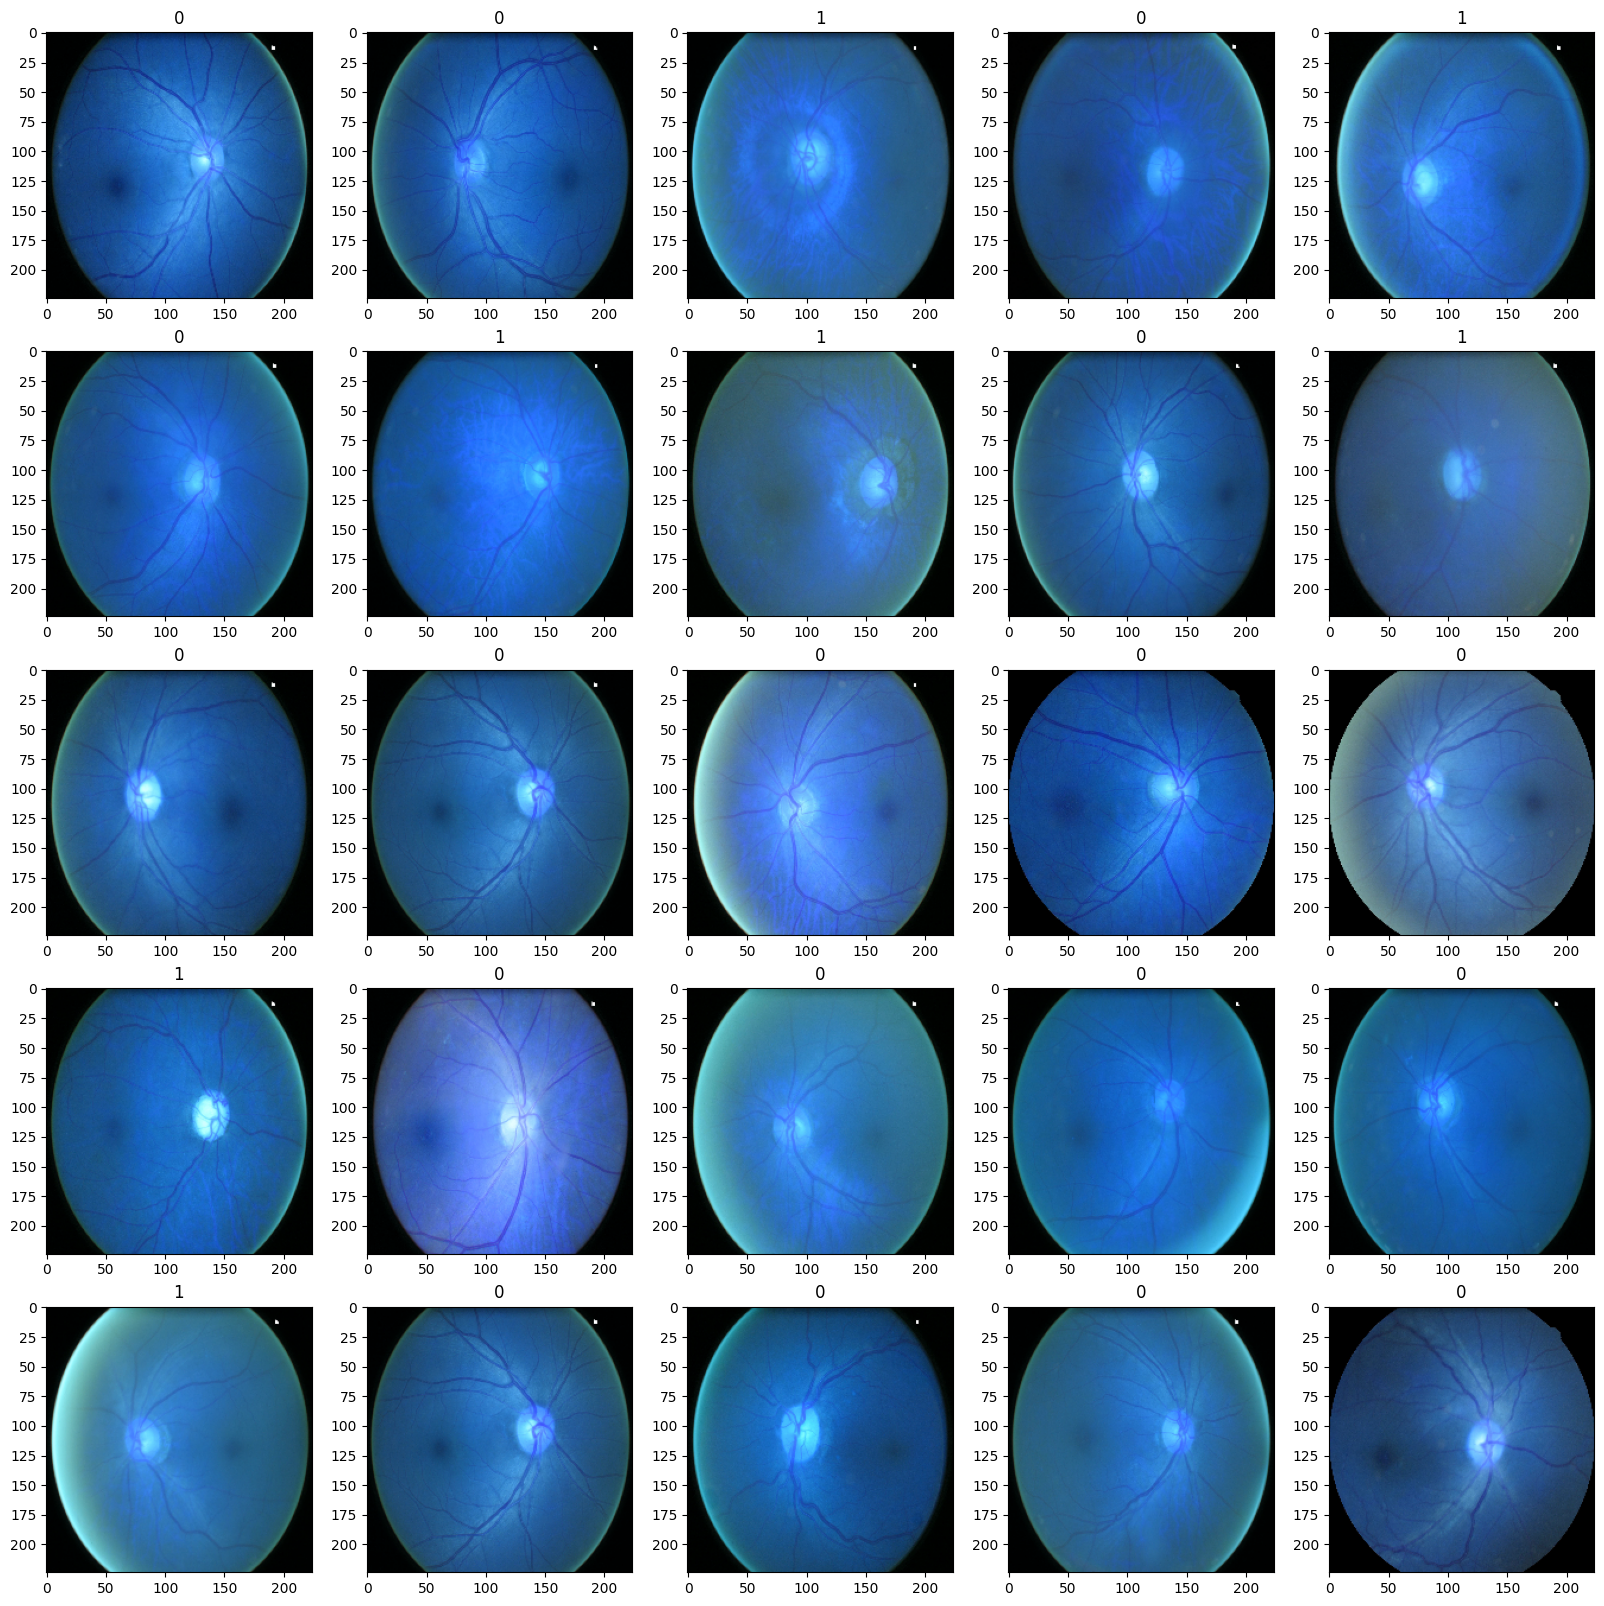

In [17]:
plt.figure(figsize=(20,20))
for i in range(1,26):
    plt.subplot(5,5,i)
    n = np.random.randint(600)
    plt.imshow(images[n])
    plt.title(labels[n])

In [18]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

images, labels = shuffle(images, labels, random_state=32)
x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.1)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1)

In [19]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                            fill_mode='constant', cval=0.)
train_gen = datagen.flow(x_train, y_train, batch_size=32)

In [20]:
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19


In [21]:
import tensorflow as tf
from tensorflow.python.ops import histogram_ops
generator = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.1,fill_mode='reflect') 


mc_filepath="E:/gp/Ocular_disease/glaucoma/callbacks/weights/weights-improvment-{epoch:02d}-{val_accuracy:.2f}.hdf5"
mc_callback = tf.keras.callbacks.ModelCheckpoint(mc_filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

csv_callback= tf.keras.callbacks.CSVLogger('E:/gp/Ocular_disease/glaucoma/callbacks/my_train.csv',separator=',',append=False)
tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir='E:/gp/Ocular_disease/glaucoma/callbacks',histogram_freq=1,write_graph=True,write_images=True)
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1,  restore_best_weights=True,monitor="val_accuracy")
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [22]:

vgg = VGG19(weights="imagenet",include_top = False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [23]:
history = model.fit_generator(train_gen, epochs=50, 
                              verbose=1, validation_data=(x_valid,y_valid),
                              callbacks=[es_callback, reduce_lr,mc_callback,tensorboard_callback,csv_callback])

C:\Users\DELL\AppData\Local\Temp\ipykernel_16656\2610198771.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=50,


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.6350 
Epoch 1: val_accuracy improved from -inf to 0.67692, saving model to E:/gp/Ocular_disease/glaucoma/callbacks/weights\weights-improvment-01-0.68.hdf5
17/17 [==============================] - 218s 13s/step - loss: 0.9046 - accuracy: 0.6350 - val_loss: 0.9433 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.7529 
Epoch 2: val_accuracy did not improve from 0.67692
17/17 [==============================] - 219s 13s/step - loss: 0.5785 - accuracy: 0.7529 - val_loss: 0.6431 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.5425 - accuracy: 0.7414 
Epoch 3: val_accuracy did not improve from 0.67692
17/17 [==============================] - 215s 13s/step - loss: 0.5425 - accuracy: 0.7414 - val_loss: 0.8472 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 4/50
17/17 [==============

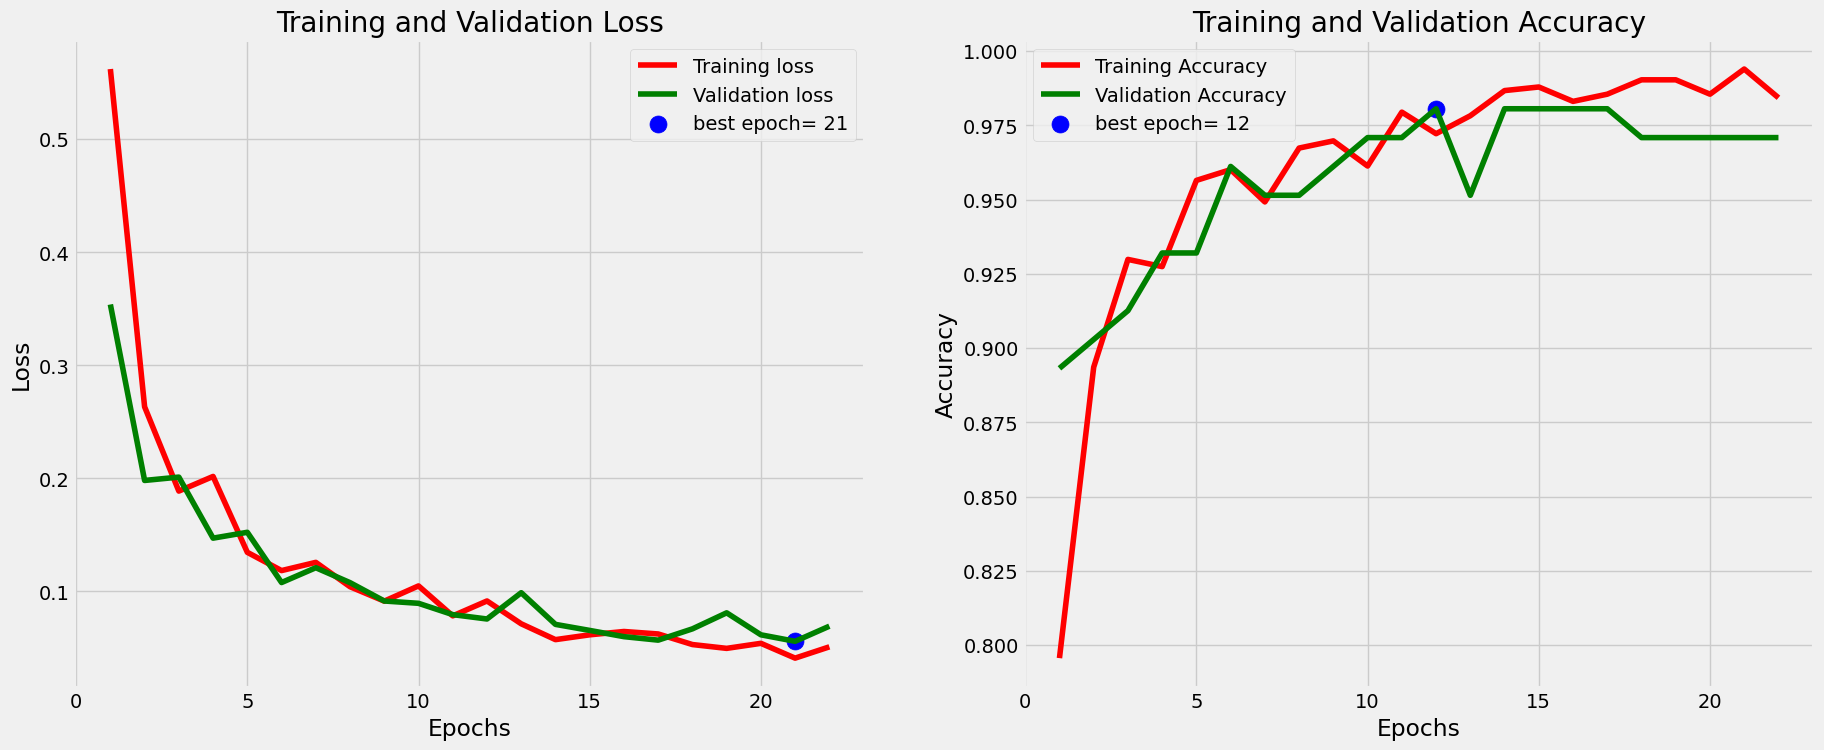

In [117]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

plot_training(history)

<AxesSubplot:>

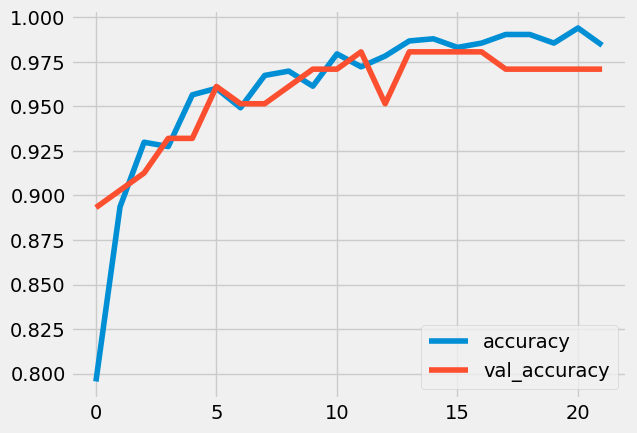

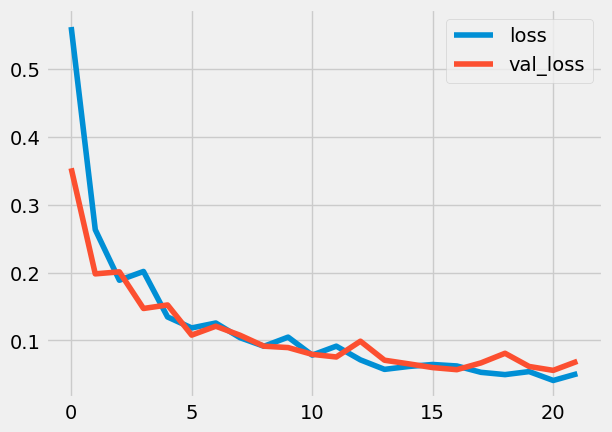

In [118]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
history_df[['loss', 'val_loss']].plot()


In [119]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

3/3 [==============================] - 31s 10s/step - loss: 0.0513 - accuracy: 0.9891
loss: 0.05134497582912445
Accuracy: 0.989130437374115


In [120]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)

3/3 [==============================] - 34s 11s/step


In [121]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred.round())

0.9891304347826086

In [122]:

print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        45

    accuracy                           0.99        92
   macro avg       0.99      0.99      0.99        92
weighted avg       0.99      0.99      0.99        92



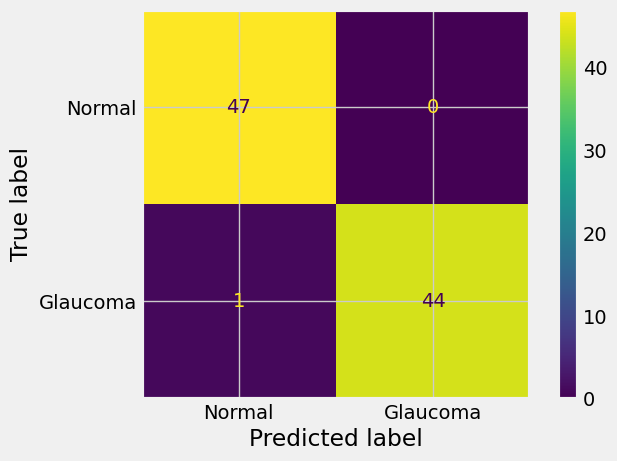

In [123]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Normal","Glaucoma"])

cm_display.plot()
plt.show()


In [124]:
#model.save("/content/gdrive/MyDrive/gp/Glaucoma/saved_model")
from sklearn.metrics import accuracy_score
model_name = 'VGG19'
subject = 'Glaucoma_classification'
acc = accuracy * 100
save_path = 'E:/gp/Ocular_disease/glaucoma/saved_model'

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')


model was saved as E:/gp/Ocular_disease/glaucoma/saved_model\VGG19-Glaucoma_classification-98.91.h5


In [1]:
import tensorflow as tf
Glaucoma_classification_model = tf.keras.models.load_model("F:/gp/Ocular_disease/glaucoma/saved_model/VGG19-Glaucoma_classification-98.91.h5")
print(Glaucoma_classification_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [6]:
import cv2

import numpy as np

image_size=224
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
        
def predict_class(image_path):

    img = cv2.imread(image_path,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

    #configure CLAHE
    clahe = cv2.createCLAHE(clipLimit=10,tileGridSize=(8,8))

    #0 to 'L' channel, 1 to 'a' channel, and 2 to 'b' channel
    img[:,:,0] = clahe.apply(img[:,:,0])

    img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)

    img= crop_image_from_gray(img)
    img = cv2.resize(img,(image_size,image_size))
    
    img=np.array(img)
    img=img.reshape(-1,image_size,image_size,3)
    img = img / 255.0
    y = Glaucoma_classification_model.predict([img])

    return y
prediction =predict_class("F:/gp/Ocular_disease/glaucoma/old_glaucoma/LAG_database_part_1/suspicious_glaucoma/image/0233.jpg")  
print(prediction[0][0])
if prediction[0][0] >0.5:
  print("Glaucoma")
else:
  print("Normal")

1/1 [==============================] - 0s 418ms/step
0.026434738
Normal
